# Cleaning and preparing an image dataset using fastdup V1.0

In [ ]:
# download fastdup
!pip install pip -U
!pip install fastdup
!pip install pandas
!pip install matplotlib
!pip install wurlitzer
%load_ext wurlitzer

In [2]:
import fastdup
import pandas as pd

# Download food-101 Dataset

In [1]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar -xf food-101.tar.gz

--2023-03-01 06:49:43--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2023-03-01 06:49:43--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  18.6MB/s    in 4m 22s  

2023-03-01 06:54:06 (18.2 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



# Run fastdup

In [3]:
images_dir = 'food-101/images/'
work_dir = 'fastdup_food101'

In [4]:
fd = fastdup.create(work_dir=work_dir, input_dir=images_dir)
fd.run()

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2023-03-01 10:55:15 [INFO] Going to loop over dir food-101/images
2023-03-01 10:55:22 [INFO] Found total 101000 images to run on
2023-03-01 11:26:06 [INFO] Found total 101000 images to run on
2023-03-01 11:36:56 [INFO] 649444) Finished write_index() NN model
2023-03-01 11:36:56 [INFO] Stored nn model index file fastdup_food101/nnf.index
2023-03-01 11:39:04 [INFO] Total time took 2622423 ms
2023-03-01 11:39:04 [INFO] Found a total of 170 fully identical images (d>0.990), which are 0.06 %
2023-03-01 11:39:04 [INFO] Found a total of 88 nearly identical images(d>0.980), which are 0.03 %
2023-03-01 11:39:04 [INFO] Found a total of 5236 above threshold images (d>0.900), which are 1.73 %
2023-03-01 11:39:04 [INFO] Found a total of 10100 outlier images         (d<0.050), which are 3.33 %
2023-03-01 11:39:04 [INFO] Min distance found 0.379 max distance 1.000
2023-03-01 11:39:04 [INFO] Running connected components for cct

# Find duplicates

In [5]:
# visualize clusters of duplicate images
fd.vis.component_gallery(max_width=800)

Output hidden; open in https://colab.research.google.com to view.

In [6]:
# get a list of clusters with duplicate images using connected components
cc_df, _ = fd.connected_components()
cc_df[cc_df['count'] > 0.0].sort_values(by=['count'], ascending=False).head()

fastdup_id  component_id     sum  count  mean_distance  min_distance  \
19859       19859         19811  5.8648    6.0         0.9775        0.9721   
21874       21874         21803  6.0000    6.0         1.0000        1.0000   
21854       21854         21803  6.0000    6.0         1.0000        1.0000   
19862       19862         19811  5.8648    6.0         0.9775        0.9721   
19861       19861         19811  5.8648    6.0         0.9775        0.9721   

       max_distance                   img_filename error_code  is_valid  
19859        0.9856  chicken_quesadilla/535057.jpg      VALID      True  
21874        1.0000       chocolate_cake/55122.jpg      VALID      True  
21854        1.0000       chocolate_cake/49494.jpg      VALID      True  
19862        0.9856  chicken_quesadilla/535546.jpg      VALID      True  
19861        0.9856  chicken_quesadilla/535532.jpg      VALID      True

## Connected Components Grouping

In [7]:
# a function to group connected components
def get_clusters(df, sort_by='count', min_count=2, ascending=False):
    # columns to aggregate
    agg_dict = {'img_filename': list, 'mean_distance': max, 'count': len}

    if 'label' in df.columns:
        agg_dict['label'] = list
    
    # filter by count
    df = df[df['count'] >= min_count]
    
    # group and aggregate columns
    grouped_df = df.groupby('component_id').agg(agg_dict)
    
    # sort
    grouped_df = grouped_df.sort_values(by=[sort_by], ascending=ascending)
    return grouped_df

In [8]:
# get clusters using connected components
cluster_df = get_clusters(cc_df)
cluster_df.head(3)

img_filename  \
component_id                                                                                   
26465               [crab_cakes/2780617.jpg, crab_cakes/2780621.jpg, crab_cakes/2780623.jpg]   
21803         [chocolate_cake/49494.jpg, chocolate_cake/51717.jpg, chocolate_cake/55122.jpg]   
35796                     [escargots/637185.jpg, escargots/637187.jpg, escargots/637188.jpg]   

              mean_distance  count  
component_id                        
26465                0.9759      3  
21803                1.0000      3  
35796                0.9798      3

In [9]:
# get clusters sorted differently
get_clusters(cc_df, sort_by='mean_distance').head(3)

img_filename  \
component_id                                                                   
131                           [apple_pie/1461580.jpg, apple_pie/1469191.jpg]   
41128         [french_onion_soup/1741871.jpg, french_onion_soup/1741875.jpg]   
57729                                 [hummus/620711.jpg, hummus/622847.jpg]   

              mean_distance  count  
component_id                        
131                     1.0      2  
41128                   1.0      2  
57729                   1.0      2

In [10]:
# It's a good start, but as we can see there are not that many duplicates here, and the data may contain more.
# Let's lower the threshold a bit and re-evaluate the duplicates case.

## Re-run with lower threshold
Now we have more clusters containing more of the images, and we are able to remove highly similar images with higher recall.

In [11]:
# run with ccthreshold = 0.9 compared to default 0.96
fd.run(ccthreshold=0.9, overwrite=True)
fd.summary()

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2023-03-01 11:48:22 [INFO] Going to loop over dir food-101/images
2023-03-01 11:48:24 [INFO] Found total 101000 images to run on
2023-03-01 12:19:09 [INFO] Found total 101000 images to run on
2023-03-01 12:29:58 [INFO] 648922) Finished write_index() NN model
2023-03-01 12:29:58 [INFO] Stored nn model index file fastdup_food101/nnf.index
2023-03-01 12:32:14 [INFO] Total time took 2630145 ms
2023-03-01 12:32:14 [INFO] Found a total of 170 fully identical images (d>0.990), which are 0.06 %
2023-03-01 12:32:14 [INFO] Found a total of 88 nearly identical images(d>0.980), which are 0.03 %
2023-03-01 12:32:14 [INFO] Found a total of 5236 above threshold images (d>0.900), which are 1.73 %
2023-03-01 12:32:14 [INFO] Found a total of 10100 outlier images         (d<0.050), which are 3.33 %
2023-03-01 12:32:14 [INFO] Min distance found 0.379 max distance 1.000
2023-03-01 12:32:14 [INFO] Running connected components for cct

['Dataset contains 101000 images',
 'Valid images are 100.00% (101,000) of the data, invalid are 0.00% (0) of the data',
 'Similarity:  1.70% (1,718) belong to 30 similarity clusters (components).',
 '98.30% (99,282) images do not belong to any similarity cluster.',
 'Largest cluster has 79 (0.08%) images.',
 'For a detailed analysis, use `.connected_components()`\n(similarity threshold used is 0.9, connected component threshold used is 0.9).\n',
 'Outliers: 5.97% (6,029) of images are possible outliers, and fall in the bottom 5.00% of similarity values.',
 'For a detailed list of outliers, use `.outliers(data=True)`.']

In [12]:
# Now we see a much larger amount of images clustered together
cc90_df, _ = fd.connected_components()
cc90_df[cc90_df['count'] > 0.0].sort_values(by=['count'], ascending=False).head()

fastdup_id  component_id      sum  count  mean_distance  min_distance  \
25103       25103         24810  73.0287   79.0         0.9244        0.9004   
40109       40109         24810  73.0287   79.0         0.9244        0.9004   
40824       40824         24810  73.0287   79.0         0.9244        0.9004   
40807       40807         24810  73.0287   79.0         0.9244        0.9004   
40787       40787         24810  73.0287   79.0         0.9244        0.9004   

       max_distance               img_filename error_code  is_valid  
25103        0.9467  club_sandwich/1318118.jpg      VALID      True  
40109        0.9467    french_fries/147628.jpg      VALID      True  
40824        0.9467   french_fries/3907871.jpg      VALID      True  
40807        0.9467   french_fries/3832957.jpg      VALID      True  
40787        0.9467   french_fries/3746805.jpg      VALID      True

In [13]:
# let's see the new clusters
fd.vis.component_gallery(max_width=800)

Output hidden; open in https://colab.research.google.com to view.

## Get a list of duplicates to remove

In [14]:
# List the largest clusters. These include non identical but larger clusters.
clusters_df = get_clusters(cc90_df)
clusters_df.head(3)

img_filename  \
component_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
24810         [club_sandwich/1297247.jpg, club_sandwich/1318118.jpg, club_sandwich/1886101.jpg, club_sandwich/2778614.jpg, club_sandwich/3106065.jpg, club_sandwich/588478.jpg, french_fries/1099260.jpg, french_fries/1295274.jpg, french_fries/1361604.jpg, french_fries/1384733.jpg, french_fries/147628.jpg, french_fries/1610240.jpg, french_fries/1692353.jpg, french_fries/1700344.jpg, french_fries/1712331.jpg, french_fries/1740113.jpg, french_fries/1810352.jpg, french_fries/1969264.jpg, french_fries/2073415.jpg, french_fries/2246387.jpg, french_fries/2348229.jpg, french_fries/2369999.jpg, french_fries/2700217.jpg, french_fries/2761796.jpg, french_fries/2885926.jpg, french_fries/2936284.jpg, french_fries/3030853.jpg, french_fries/3069835.jpg, french_fries/3359887.jpg, french_fries/3405511.jpg, french_fries/3423618.jpg, french_fries/3499831.jpg, french_fries/3669402.jpg, french_fries/3673168.jpg, french_fries/3697215.jpg, french_fries/3746805.jpg, french_fries/3832957.jpg, french_fries/3907871.jpg, french_fries/467106.jpg, french_fries/889641.jpg]   
18229                                                                    [chicken_curry/2394967.jpg, chicken_curry/2701143.jpg, chicken_curry/882723.jpg, hot_and_sour_soup/1151861.jpg, hot_and_sour_soup/1167380.jpg, hot_and_sour_soup/1400511.jpg, hot_and_sour_soup/1617113.jpg, hot_and_sour_soup/1670529.jpg, hot_and_sour_soup/2041812.jpg, hot_and_sour_soup/2367229.jpg, hot_and_sour_soup/2377494.jpg, hot_and_sour_soup/2520927.jpg, hot_and_sour_soup/3086202.jpg, hot_and_sour_soup/3113531.jpg, hot_and_sour_soup/3286625.jpg, hot_and_sour_soup/3428336.jpg, hot_and_sour_soup/3452669.jpg, hot_and_sour_soup/3552976.jpg, hot_and_sour_soup/3567487.jpg, hot_and_sour_soup/3568665.jpg, hot_and_sour_soup/3601021.jpg, hot_and_sour_soup/3706507.jpg, hot_and_sour_soup/387487.jpg, hot_and_sour_soup/478316.jpg, hot_and_sour_soup/564763.jpg, lobster_bisque/1346617.jpg, lobster_bisque/1826587.jpg, lobster_bisque/2917736.jpg, lobster_bisque/3282626.jpg, lobster_bisque/3319694.jpg, lobster_bisque/3358721.jpg, lobster_bisque/3414592.jpg, lobster_bisque/3466502.jpg]   
26394                                                                                                                                 [crab_cakes/3467918.jpg, pad_thai/1709738.jpg, pad_thai/3059603.jpg, spaghetti_bolognese/3565695.jpg, spaghetti_carbonara/1117183.jpg, spaghetti_carbonara/1390373.jpg, spaghetti_carbonara/1559267.jpg, spaghetti_carbonara/1668631.jpg, spaghetti_carbonara/1739526.jpg, spaghetti_carbonara/1891700.jpg, spaghetti_carbonara/190173.jpg, spaghetti_carbonara/1936669.jpg, spaghetti_carbonara/1940255.jpg, spaghetti_carbonara/2228065.jpg, spaghetti_carbonara/2281641.jpg, spaghetti_carbonara/2567706.jpg, spaghetti_carbonara/2774715.jpg, spaghetti_carbonara/2796656.jpg, spaghetti_carbonara/2835081.jpg, spaghetti_carbonara/2967972.jpg, spaghetti_carbonara/2980079.jpg, spaghett

In [15]:
# List the clusters with the highest similarity. These are identical but smaller clusters.
get_clusters(cc90_df, sort_by='mean_distance').head(3)

img_filename  mean_distance  \
component_id                                                                    
131             [apple_pie/1461580.jpg, apple_pie/1469191.jpg]            1.0   
31820             [dumplings/167000.jpg, dumplings/180290.jpg]            1.0   
48041         [greek_salad/857079.jpg, greek_salad/862426.jpg]            1.0   

              count  
component_id         
131               2  
31820             2  
48041             2

In [16]:
# First sample from each cluster that is kept
cluster_images_to_keep = []
cluster_images_to_discard = []

for cluster_file_list in clusters_df.img_filename:
    # keep first file, discard rest
    keep = cluster_file_list[0]
    discard = cluster_file_list[1:]
    
    cluster_images_to_keep.append(keep)
    cluster_images_to_discard.extend(discard)

cluster_images_to_discard = set(cluster_images_to_discard)
print(f"Found {len(cluster_images_to_discard)} highly similar images to discard")

Found 2153 highly similar images to discard


# Find outliers

In [17]:
# show furthest outliers
fd.outliers().head(5)

index  outlier  nearest  distance          img_filename_outlier  \
0  10099     9797    96131  0.379365  breakfast_burrito/462294.jpg   
1  10098    63325    38290  0.429241          macarons/2117640.jpg   
2  10095    96131    83667  0.515785             tacos/1505262.jpg   
3  10094    89017    25421  0.528563  shrimp_and_grits/1047420.jpg   
4  10093    95577    22575  0.546918             sushi/3100962.jpg   

  error_code_outlier  is_valid_outlier         img_filename_nearest  \
0              VALID              True            tacos/1505262.jpg   
1              VALID              True   fish_and_chips/2079080.jpg   
2              VALID              True  red_velvet_cake/3143813.jpg   
3              VALID              True    club_sandwich/2465517.jpg   
4              VALID              True  chocolate_mousse/303176.jpg   

  error_code_nearest  is_valid_nearest  
0              VALID              True  
1              VALID              True  
2              VALID              True  
3              VALID              True  
4              VALID              True

100%|██████████| 20/20 [00:00<00:00, 7099.36it/s]

fastdup_food101/galleries/outliers_20230301125846/food-101_images_breakfast_burrito_462294_9797.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_macarons_2117640_63325.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_tacos_1505262_96131.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_shrimp_and_grits_1047420_89017.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_sushi_3100962_95577.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_pho_2399877_75357.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_pho_1840846_75236.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_chocolate_cake_2518457_21410.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_red_velvet_cake_2894652_83590.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_macarons_3785921_63762.0.jpg.jp

fastdup_food101/galleries/outliers_20230301125846/food-101_images_pad_thai_2614597_70494.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_prime_rib_587532_79858.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_macarons_2591602_63463.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_tacos_1091159_96024.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_hamburger_1608876_53171.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_frozen_yogurt_3577020_45688.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_peking_duck_388951_74793.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_steak_2788759_93480.0.jpg.jpg
fastdup_food101/galleries/outliers_20230301125846/food-101_images_ice_cream_1837798_58194.0.jpg.jpg
Stored outliers visual view in  fastdup_food101/galleries/outliers_20230301125846/outliers.html



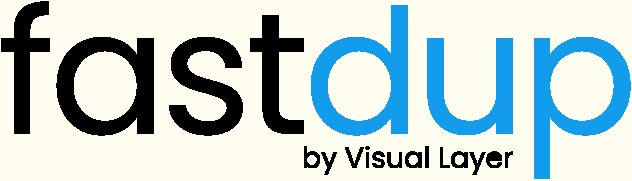
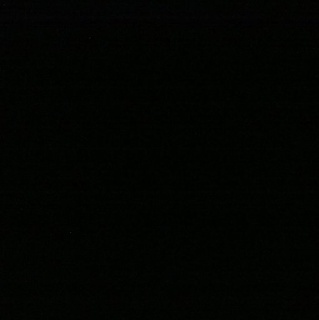
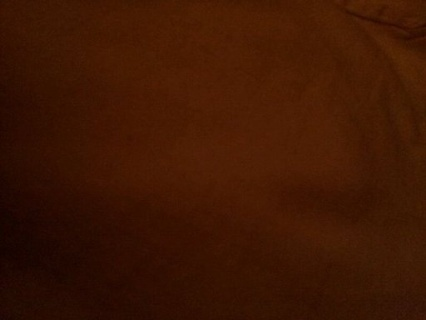
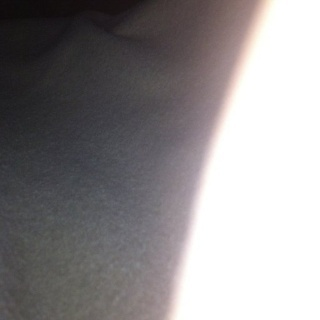
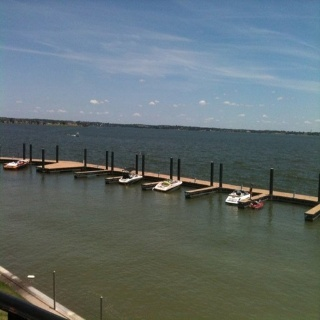
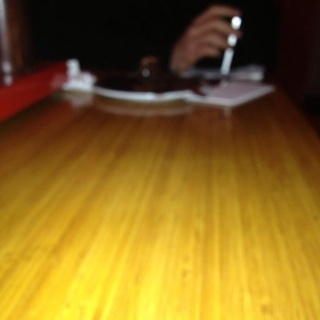
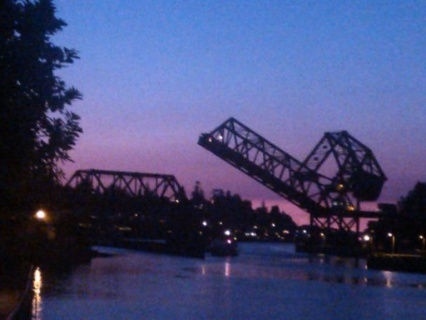
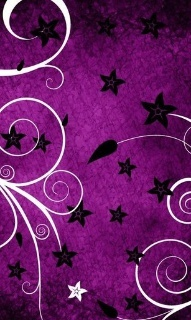
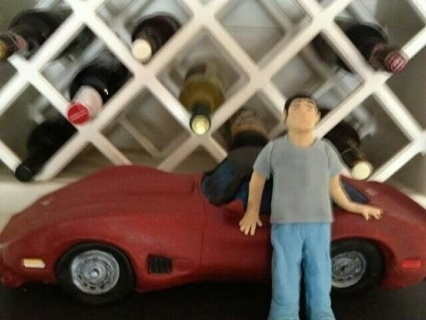
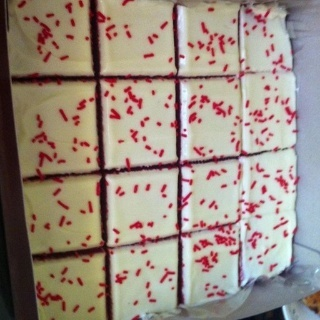
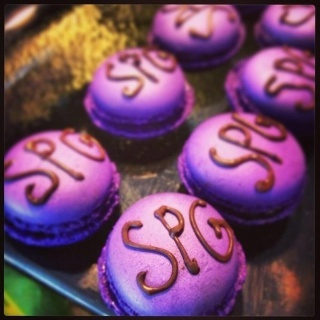
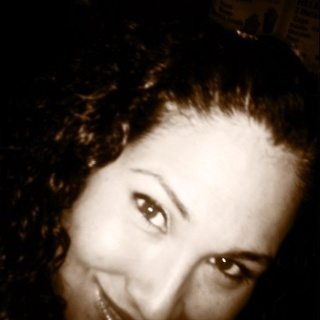
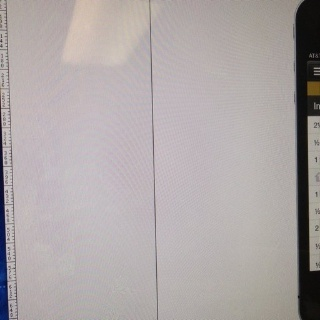
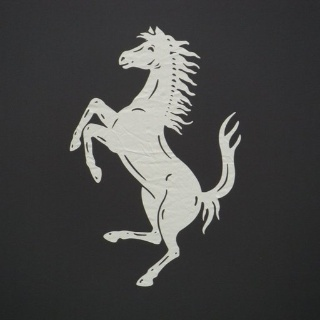
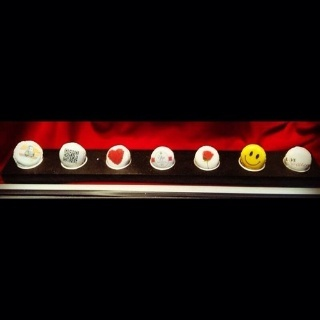
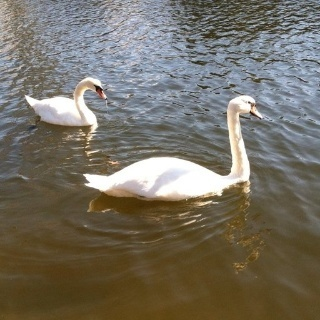
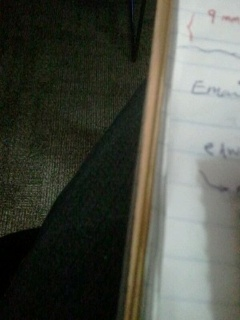
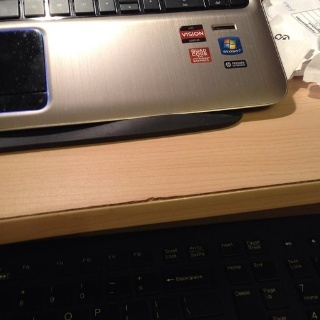
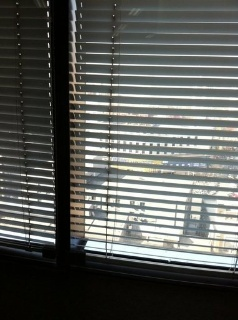
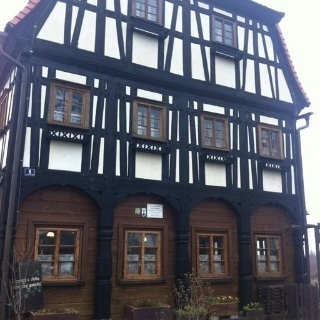
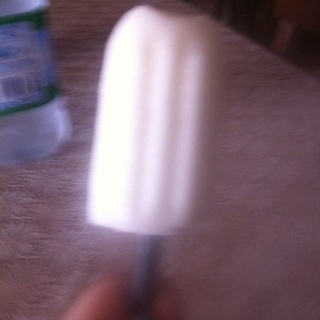

In [18]:
# visualize outliers
fd.vis.outliers_gallery()

# Remove broken images
Using fastdup we are able to recover a list of files that are corrupted or that could not be loaded from various reasons. The reason is listed for each image. We will fetch them, and add them to our list of images to remove. Food-101 is meticoulsly curated, so just for the sake of demonstration we've added one empty image.

In [19]:
inv = fd.invalid_instances()
inv

Empty DataFrame
Columns: [img_filename, fastdup_id, error_code, is_valid]
Index: []

In [20]:
inv = pd.DataFrame([['apple_pie/broken_image.jpg', 101001, 'ERROR_ZERO_SIZE_FILE', False]], columns=[inv.columns])
inv

img_filename fastdup_id            error_code is_valid
0  apple_pie/broken_image.jpg     101001  ERROR_ZERO_SIZE_FILE    False

# Find dark, bright and blurry images

In [21]:
# show image statistics
fd.img_stats().head(5)

fastdup_id  img_w  img_h  unique       blur      mean  min    max     stdv  \
0           0    308    512       0  2538.7280  113.0935  0.0  255.0  53.7116   
1           1    512    512       0   334.7137  131.6409  4.0  255.0  55.6296   
2           2    384    512       0   728.2955  117.8109  0.0  255.0  29.5684   
3           3    512    512       0  1013.1310   95.8764  0.0  255.0  67.6263   
4           4    512    512       0  2478.7454   63.2681  0.0  255.0  68.2799   

   file_size  contrast           img_filename error_code  is_valid  
0      42196    1.0000  apple_pie/1005649.jpg      VALID      True  
1      40760    0.9691  apple_pie/1011328.jpg      VALID      True  
2      33835    1.0000   apple_pie/101251.jpg      VALID      True  
3      48051    1.0000  apple_pie/1014775.jpg      VALID      True  
4      59055    1.0000  apple_pie/1026328.jpg      VALID      True

100%|██████████| 25/25 [00:00<00:00, 115.30it/s]


Stored blur visual view in  fastdup_food101/galleries/stats_20230301125905/blur.html



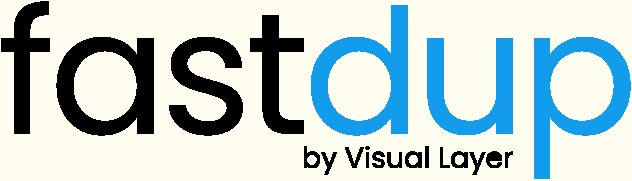
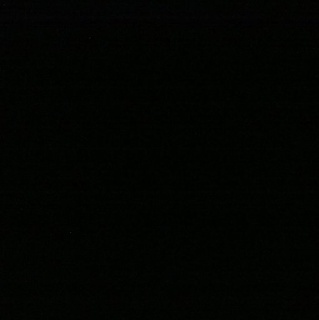
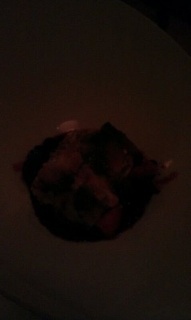
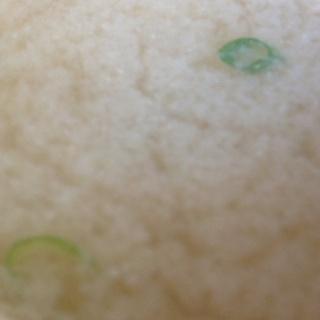
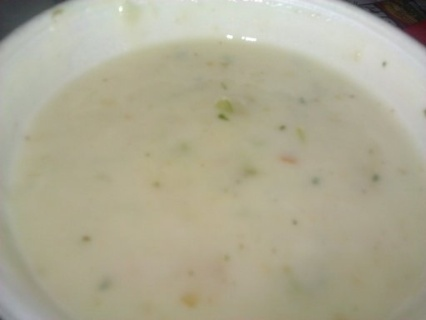
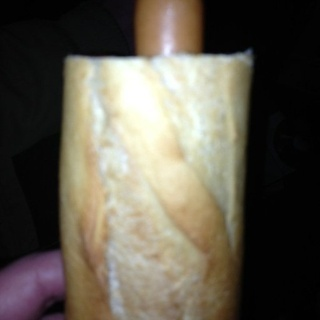
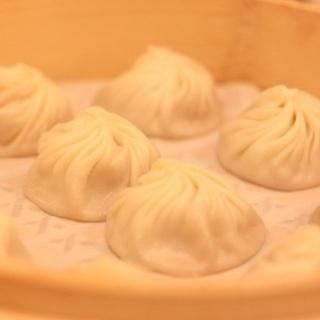
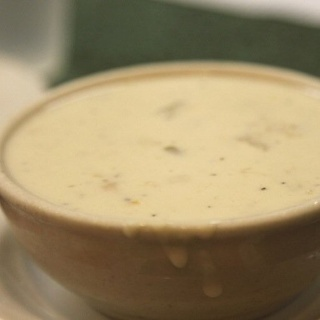
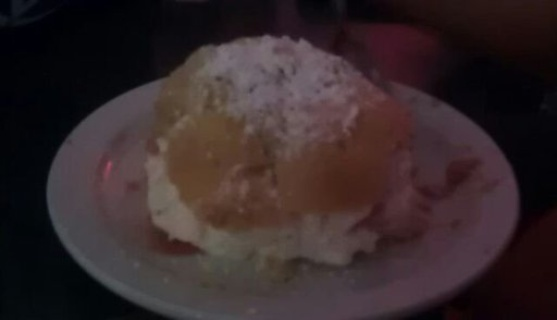
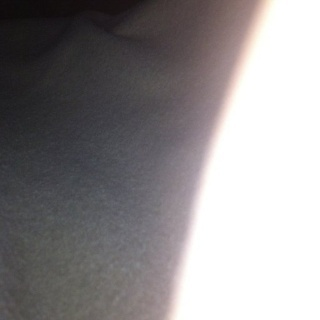
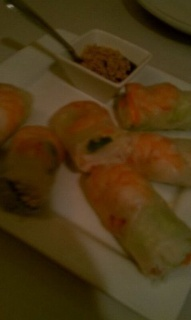
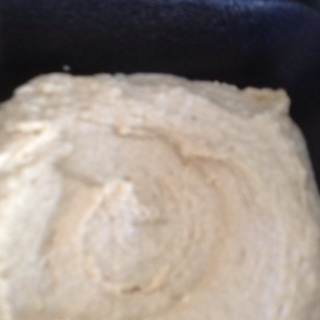
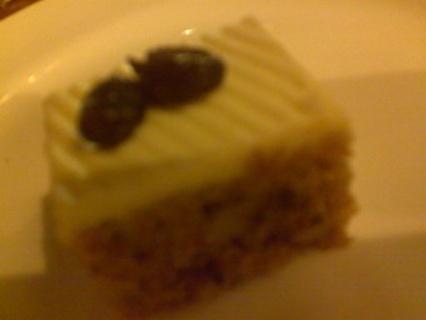
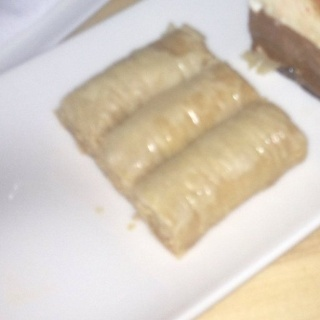
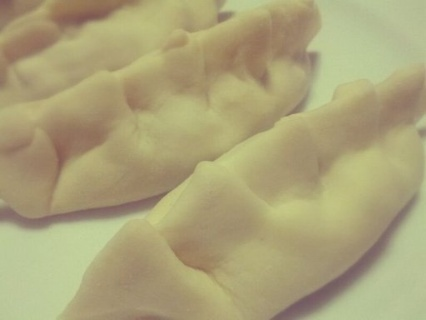
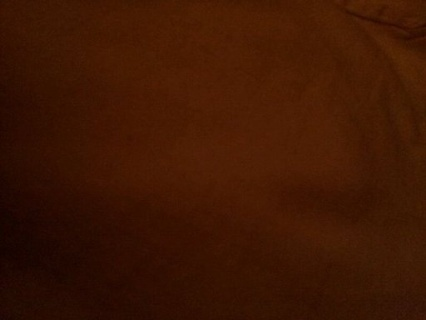
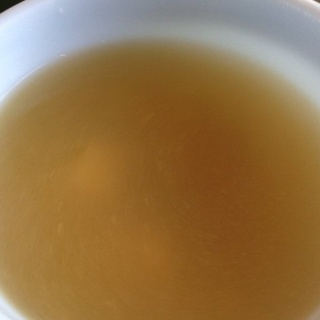
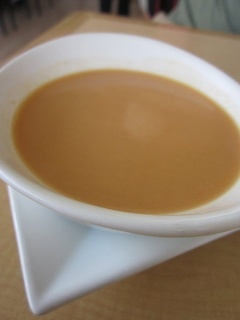
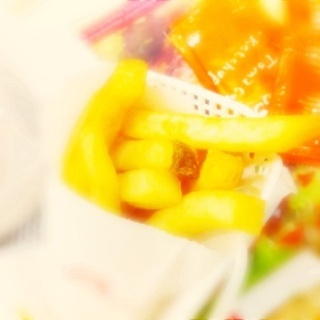
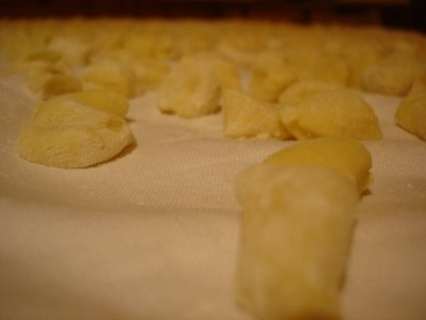
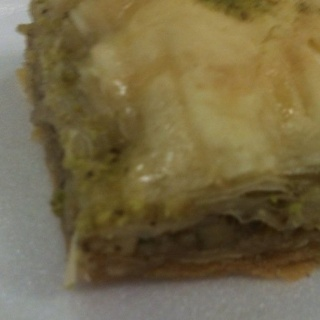
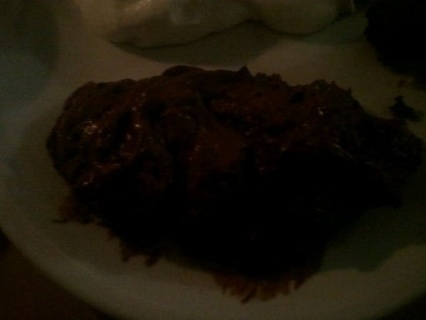
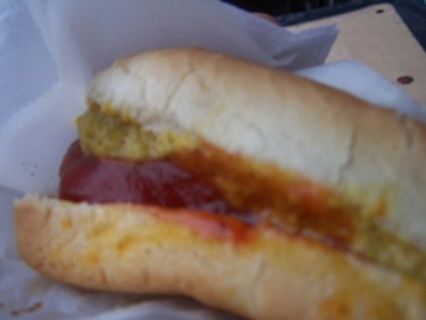
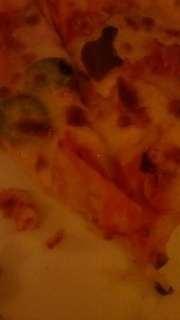
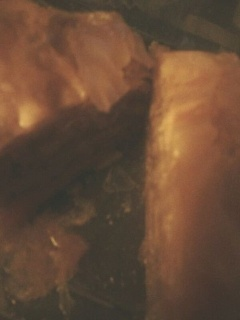
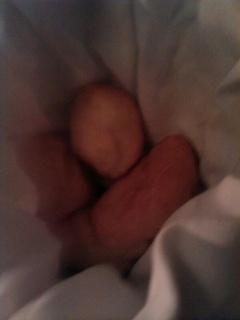

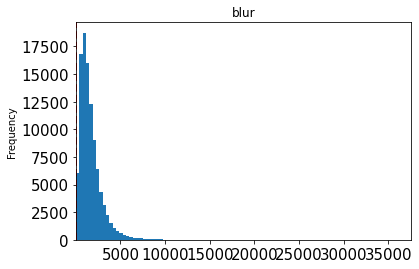

In [22]:
# visualize blurry images
fd.vis.stats_gallery(metric='blur')

100%|██████████| 25/25 [00:00<00:00, 62.25it/s]


Stored mean visual view in  fastdup_food101/galleries/stats_20230301125959/mean.html



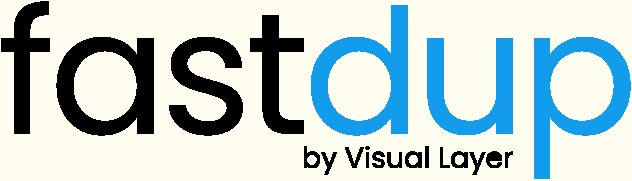
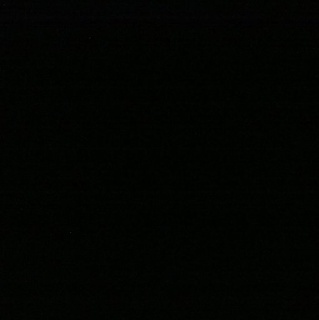
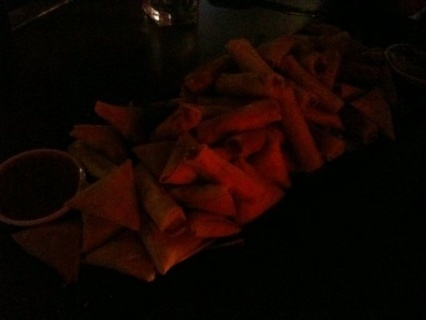
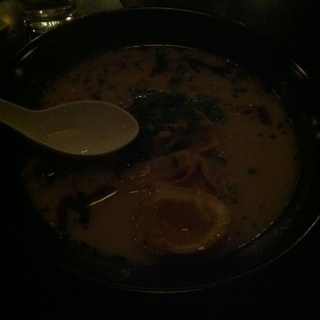
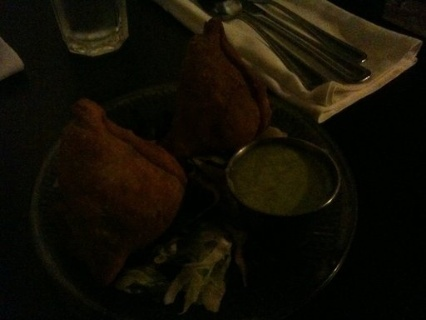
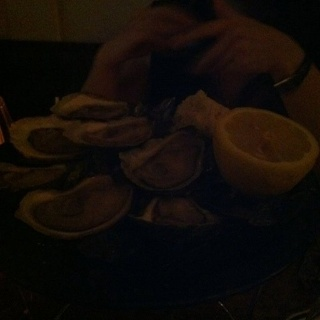
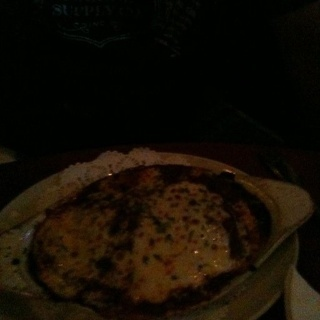
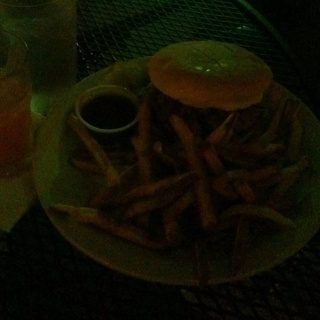
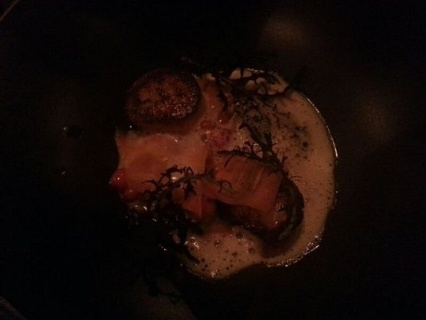
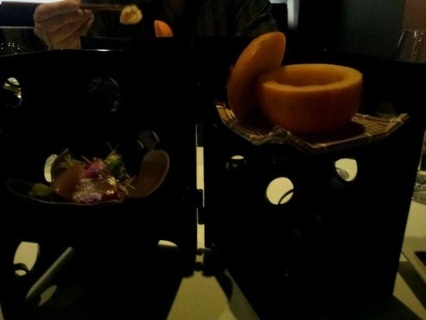
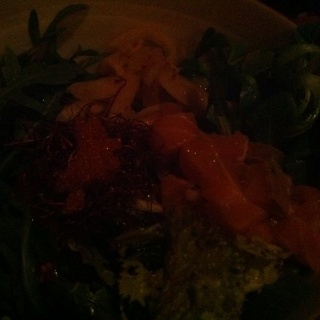
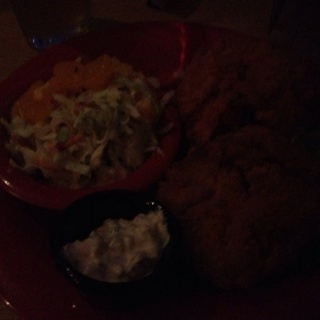
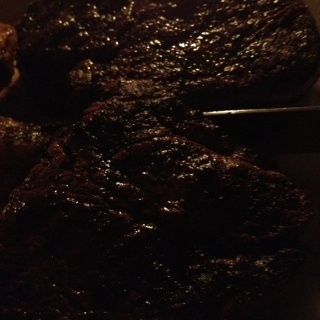
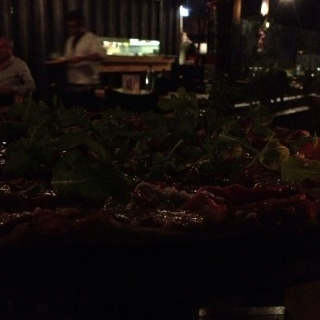
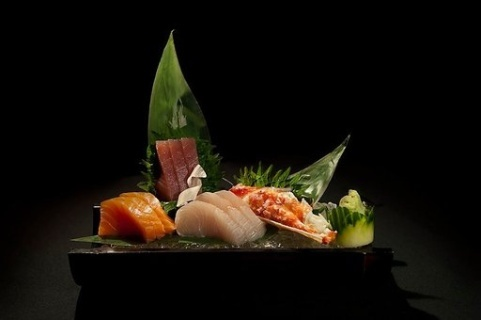
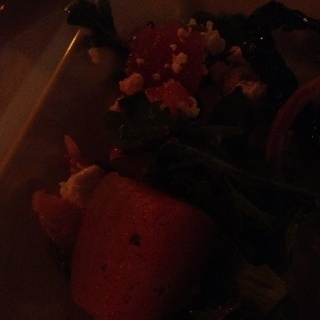
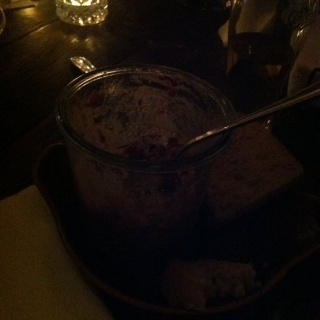
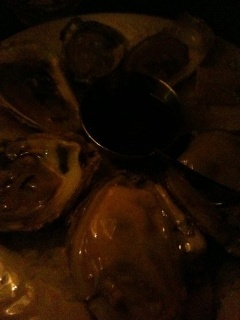
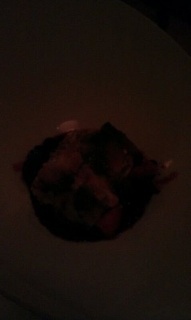
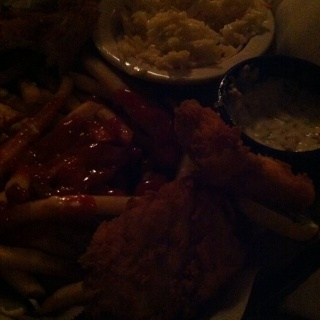
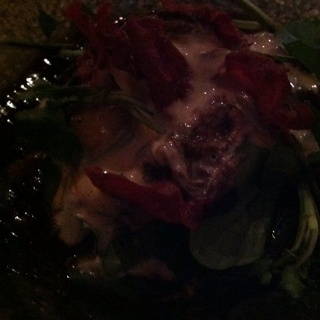
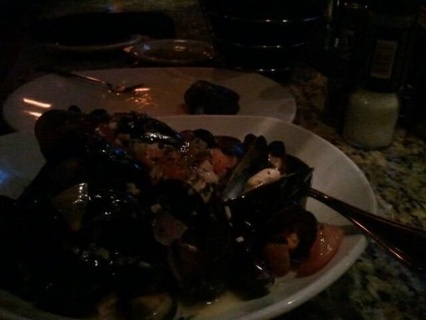
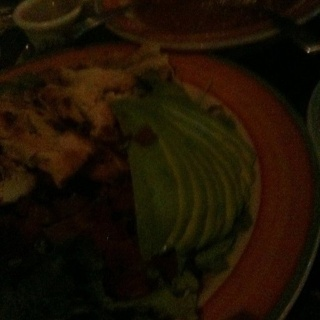
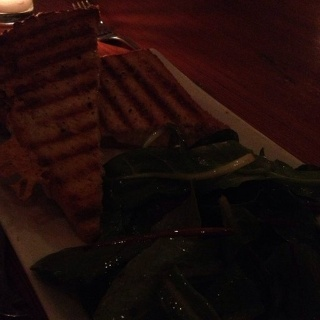
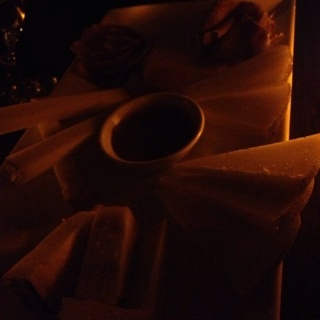
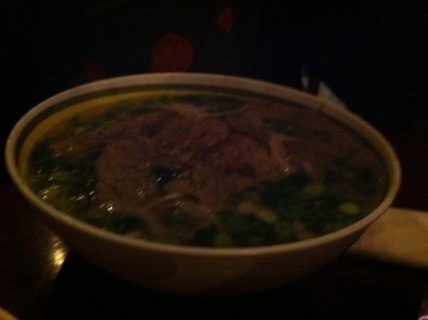

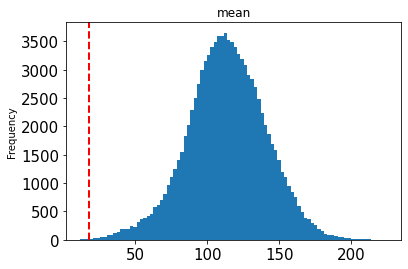

In [23]:
# visualize dark images
fd.vis.stats_gallery(metric='dark')

100%|██████████| 25/25 [00:00<00:00, 77.49it/s]


Stored mean visual view in  fastdup_food101/galleries/stats_20230301130104/mean.html



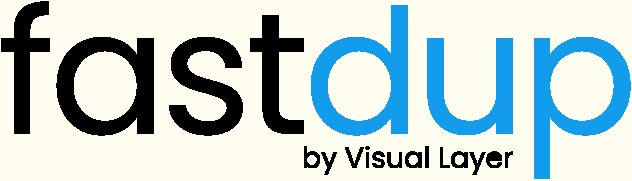
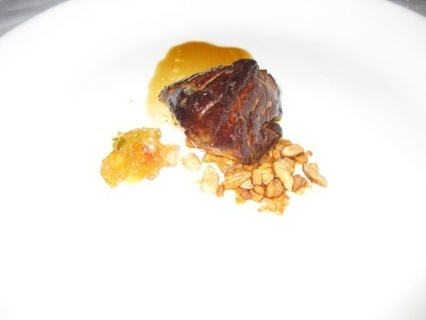
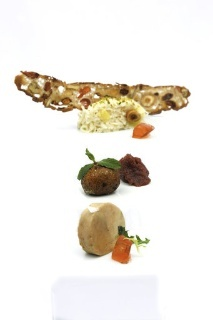
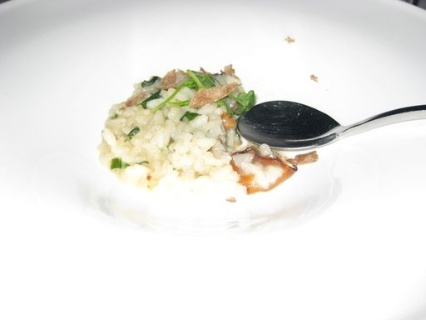
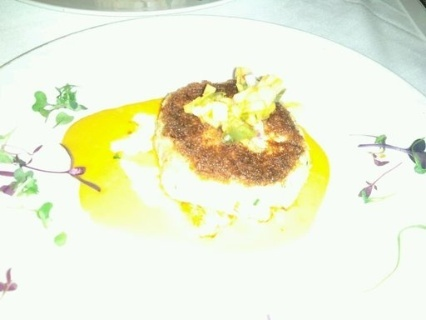
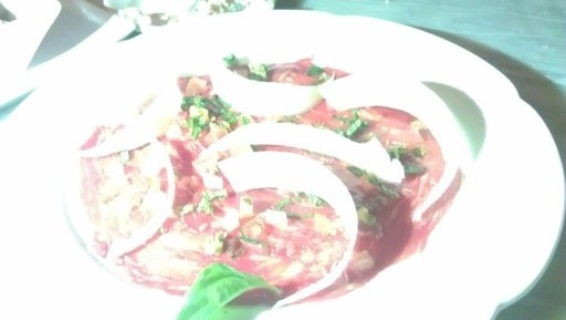
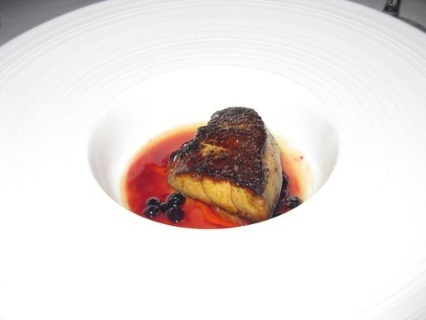
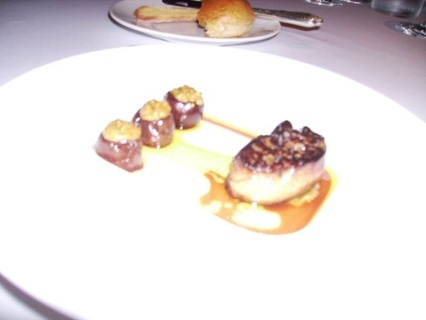
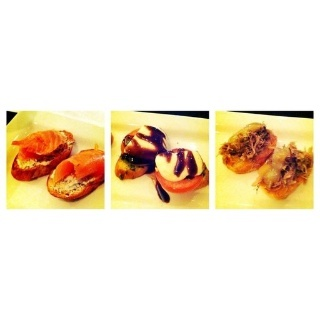
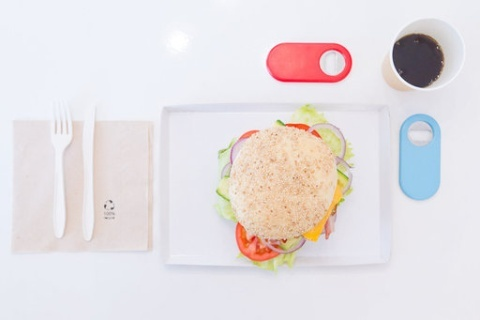
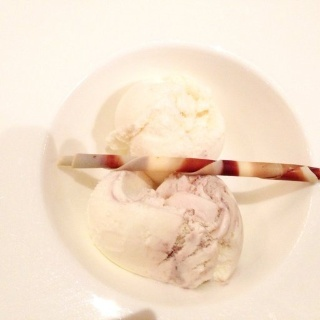
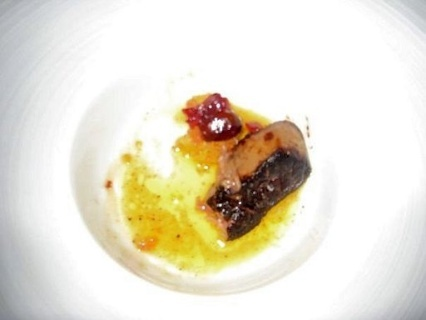
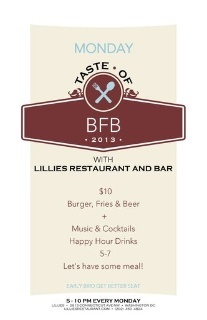
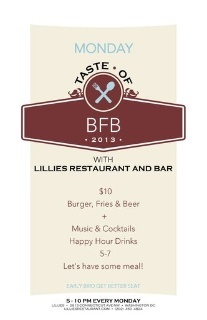
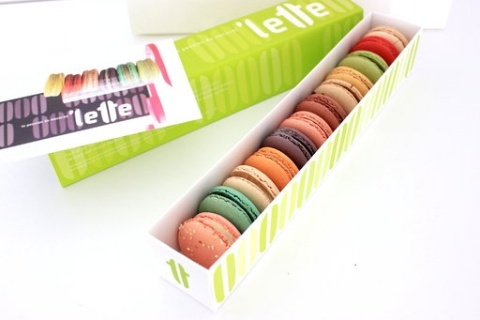
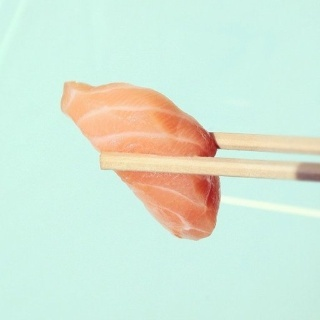
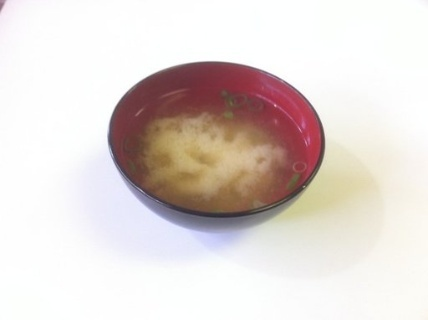
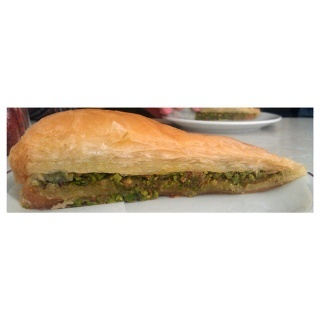
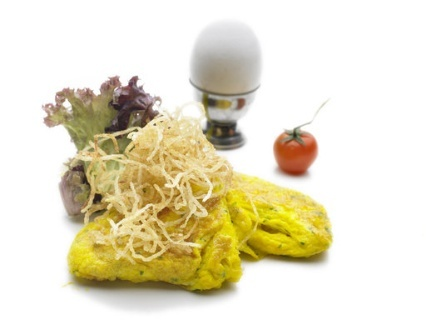
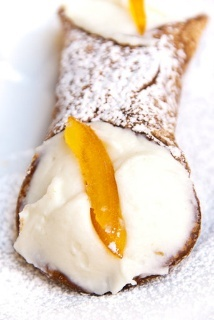
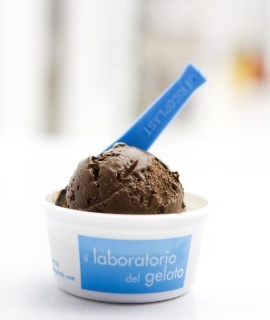
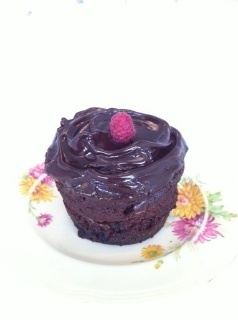
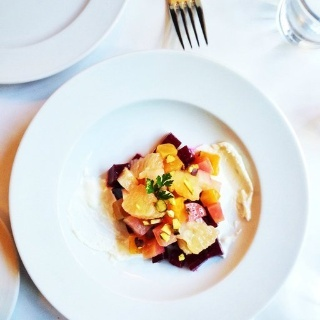
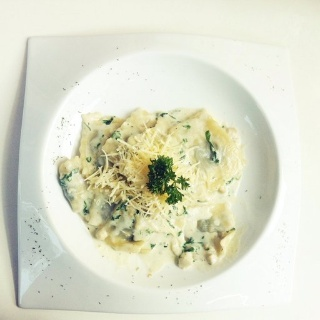
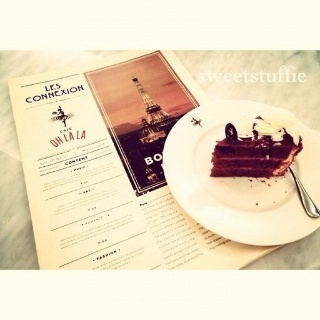
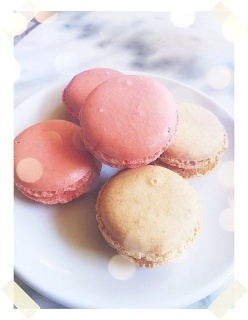

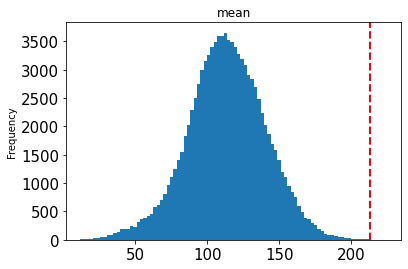

In [24]:
# visualize bright images
fd.vis.stats_gallery(metric='bright')

# Wrap up and collect file list

In [25]:
# let's collect all files to remove
stats_df = fd.img_stats()
outlier_df = fd.outliers()

# for outliers, we'll take images which their closest similarity is lower than 0.68
outliers_filtered = outlier_df[outlier_df.distance < 0.68].img_filename_outlier.tolist()

images_to_remove = dict(
    duplicates = list(cluster_images_to_discard), # the duplicates threshold is 0.9, the same ccthreshold we ran fastdup with
    outliers_to_discard = outliers_filtered,
    invalid_images = fd.invalid_instances(),
    blurry_images = stats_df[stats_df['blur'] < 50], # we'll choose blur threshold as 50
    dark_images = stats_df[stats_df['mean'] < 13], # darkness threshold as 13
    bright_images = stats_df[stats_df['mean'] > 220.5], # and brightness threshold as 220.5
)

In [26]:
# we'll create a set of unique images to remove
images_to_discard = []

for key, data_slice in images_to_remove.items():
    ext = data_slice if isinstance(data_slice, list) else data_slice['img_filename'].tolist()
    print(f"{key}: {len(data_slice)}")
    images_to_discard.extend(ext)
print(f"Total - {len(set(images_to_discard))} unique images")

duplicates: 2153
outliers_to_discard: 174
invalid_images: 0
blurry_images: 30
dark_images: 6
bright_images: 13
Total - 2368 unique images


# Summary 
Even under restrictive thresholds, we have found 2,368 images that should not be included in our labeling or training using this data.